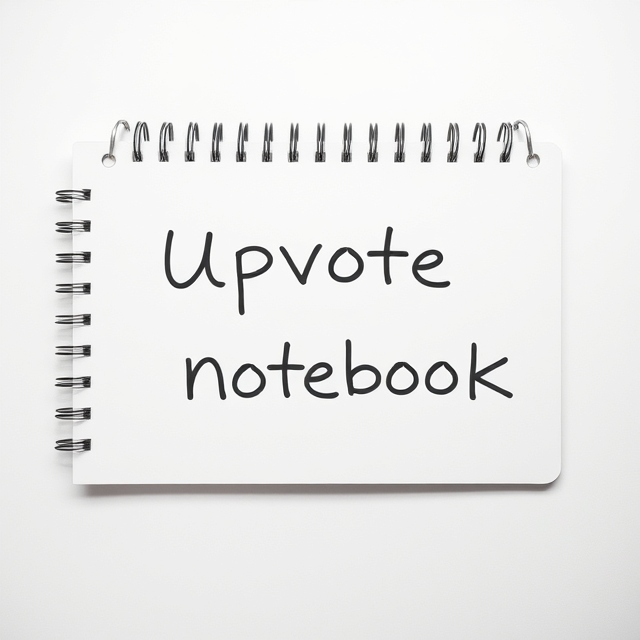

# 1. Import Libraries

In [62]:
import os
import random
import ntpath
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import FileLink
from imgaug import augmenters as iaa
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from keras import metrics
from keras import regularizers, optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, ELU, Input, Lambda, BatchNormalization

# 2. Dataset Import

In [6]:
def create_zip(source_folder, destination_zip):
    with zipfile.ZipFile(destination_zip, 'w', zipfile.ZIP_DEFLATED) as zip_ref:
        for root, dirs, files in os.walk(source_folder):
            for file in files:
                file_path = os.path.join(root, file)
                zip_ref.write(file_path, arcname=os.path.relpath(file_path, source_folder))

In [7]:
def extract_zip(zip_file, destination_folder):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(destination_folder)

In [16]:
source_folder = '/kaggle/input/training-car'
destination_zip = '/kaggle/working/dataset.zip'
destination_folder = '/kaggle/working/'

create_zip(source_folder, destination_zip)
extract_zip(destination_zip, destination_folder)

# 3. Create Dataset 

In [21]:
path = 'dataset/data/data.csv'
data_frame = pd.read_csv(path)
center = data_frame[data_frame.columns[0]].values
left = data_frame[data_frame.columns[1]].values
right = data_frame[data_frame.columns[2]].values
steering = data_frame[data_frame.columns[3]].values

In [24]:
data_frame

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236
...,...,...,...,...,...,...,...
8031,IMG/center_2016_12_01_13_46_38_745.jpg,IMG/left_2016_12_01_13_46_38_745.jpg,IMG/right_2016_12_01_13_46_38_745.jpg,0.0,0.0,0.0,1.402436
8032,IMG/center_2016_12_01_13_46_38_802.jpg,IMG/left_2016_12_01_13_46_38_802.jpg,IMG/right_2016_12_01_13_46_38_802.jpg,0.0,0.0,0.0,1.393976
8033,IMG/center_2016_12_01_13_46_38_846.jpg,IMG/left_2016_12_01_13_46_38_846.jpg,IMG/right_2016_12_01_13_46_38_846.jpg,0.0,0.0,0.0,1.388364
8034,IMG/center_2016_12_01_13_46_38_922.jpg,IMG/left_2016_12_01_13_46_38_922.jpg,IMG/right_2016_12_01_13_46_38_922.jpg,0.0,0.0,0.0,1.377208


In [22]:
def flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle
    
    return image, steering_angle

In [26]:
train_x = []
train_y = []

img_folder = 'dataset/data/IMG'
steering_adjust_factor = 0.2
image_height = 100 
image_width = 100

for i in range(8036):
    for choice in range(3):
        if choice == 0:
            img = cv2.imread(os.path.join(img_folder, center[i].split('IMG/')[1]))
            steering_angle = steering[i]
        elif choice == 1:
            img = cv2.imread(os.path.join(img_folder, left[i].split('IMG/')[1]))
            steering_angle = steering[i] + steering_adjust_factor
        elif choice == 2:
            img = cv2.imread(os.path.join(img_folder, right[i].split('IMG/')[1]))
            steering_angle = steering[i] - steering_adjust_factor
        
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:, :, 1]
        img = cv2.resize(img, (image_height, image_width))
        
        train_x.append(img)
        train_y.append(steering_angle)
        
        flip_img, steering_angle = flip(img, steering_angle)
                
        train_x.append(flip_img)
        train_y.append(steering_angle)

train_x = np.array(train_x)
train_x = np.reshape(train_x, [train_x.shape[0], train_x.shape[1], train_x.shape[2], 1])

train_y = np.array(train_y)
train_y = np.reshape(train_y, [train_y.shape[0], 1])

print(train_x.shape)
print(train_y.shape)

(48216, 100, 100, 1)
(48216, 1)


# 4. Model 

In [27]:
def model(height, width):
    input_layer = Input(shape=(height, width, 1))
    normalized_input = Lambda(lambda x: x / 127.5 - 1.0)(input_layer)
    
    conv_1 = Conv2D(32, (3, 3), padding='same')(normalized_input)
    conv_1_elu = ELU()(conv_1)
    
    conv_2 = Conv2D(32, (3, 3), padding='same')(conv_1_elu)
    conv_2_elu = ELU()(conv_2)
    maxpool_1 = MaxPooling2D((2, 2), padding='valid')(conv_2_elu)
    
    conv_3 = Conv2D(64, (3, 3), padding='same')(maxpool_1)
    conv_3_elu = ELU()(conv_3)
    conv_4 = Conv2D(64, (3, 3), padding='same')(conv_3_elu)
    conv_4_elu = ELU()(conv_4)
    maxpool_2 = MaxPooling2D((2, 2), padding='valid')(conv_4_elu)
    
    conv_5 = Conv2D(128, (3, 3), padding='same')(maxpool_2)
    conv_5_elu = ELU()(conv_5)
    maxpool_3 = MaxPooling2D((2, 2), padding='valid')(conv_5_elu)
    
    conv_6 = Conv2D(128, (3, 3), padding='same')(maxpool_3)
    conv_6_elu = ELU()(conv_6)
    maxpool_4 = MaxPooling2D((2, 2), padding='valid')(conv_6_elu)
    
    flattened_output = Flatten()(maxpool_4)
    dropout_layer = Dropout(0.5)(flattened_output)
    batch_normalized = BatchNormalization()(dropout_layer)
    
    dense_1 = Dense(512)(batch_normalized)
    dense_2 = Dense(256)(dense_1)
    dense_3 = Dense(64)(dense_2)
    
    output_layer = Dense(1)(dense_3)
    
    model = Model(inputs=input_layer, outputs=output_layer, name='Model')
    
    return model

In [28]:
model = model(image_height, image_width)
print(model.summary())

Model: "Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu (ELU)                       │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_1 (ELU)                     │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_2 (ELU)                     │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_3 (ELU)                     │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_4 (ELU)                     │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_5 (ELU)                     │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4608)           │        18,432 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,812,513 (10.73 MB)

 Trainable params: 2,803,297 (10.69 MB)

 Non-trainable params: 9,216 (36.00 KB)

None


In [31]:
optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

In [32]:
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, random_state=42, test_size=.20)

# 5. Train

In [33]:
results = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=16, epochs=10)

Epoch 1/10


I0000 00:00:1734014436.404668     396 service.cc:145] XLA service 0x7b49f0013490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734014436.404719     396 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  21/2411 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 7.1776 - mse: 7.1776 

I0000 00:00:1734014441.279110     396 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2411/2411 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - loss: 0.9355 - mse: 0.9355 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 2/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0220 - mse: 0.0220 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 3/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0181 - mse: 0.0181 - val_loss: 0.0125 - val_mse: 0.0125
Epoch 4/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0166 - mse: 0.0166 - val_loss: 0.0156 - val_mse: 0.0156
Epoch 5/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0149 - mse: 0.0149 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 6/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 7/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 8/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 9/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 

In [34]:
model.save('best.h5')

In [35]:
!zip best.zip best.h5

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: best.h5 (deflated 9%)


In [36]:
FileLink('best.zip')

/kaggle/working/best.zip

# 6. Test

In [45]:
model = load_model('best.h5', custom_objects={'mse': metrics.MeanSquaredError()})

In [47]:
resized_x_test = np.array([cv2.resize(image, (100, 100)) for image in x_test])

In [48]:
y_test = np.array(y_test).reshape(-1, 1)

In [49]:
loss, mse = model.evaluate(resized_x_test, y_test, batch_size=16)

603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0127 - mean_squared_error: 0.0129


In [50]:
predictions = model.predict(resized_x_test)

302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [67]:
random_indices = np.random.choice(len(predictions), size=20, replace=False)
random_predictions = predictions[random_indices]
random_y_test = y_test[random_indices]

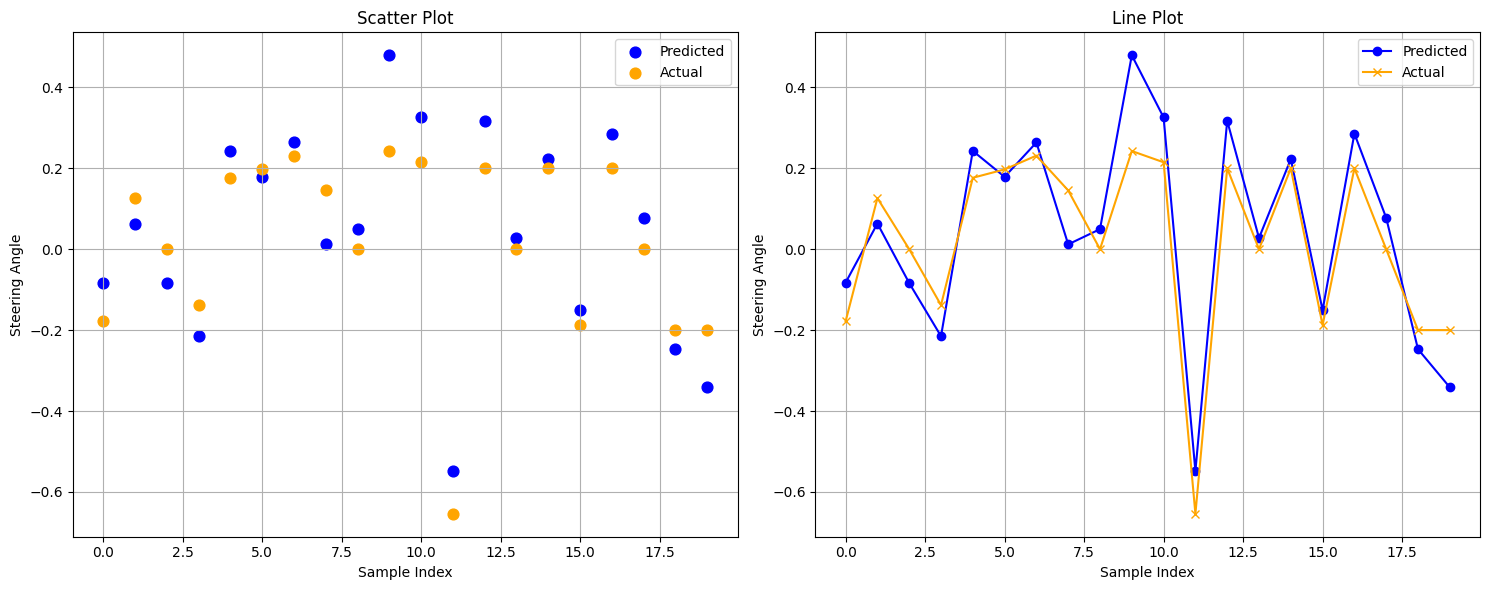

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].scatter(range(20), random_predictions, label="Predicted", color='blue', s=60)
axs[0].scatter(range(20), random_y_test, label="Actual", color='orange', s=60)
axs[0].set_title("Scatter Plot")
axs[0].set_xlabel("Sample Index")
axs[0].set_ylabel("Steering Angle")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(random_predictions, label="Predicted", marker='o', color='blue')
axs[1].plot(random_y_test, label="Actual", marker='x', color='orange')
axs[1].set_title("Line Plot")
axs[1].set_xlabel("Sample Index")
axs[1].set_ylabel("Steering Angle")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()